<a href="https://colab.research.google.com/github/Ilvecho/Project_6/blob/main/Project_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install TTS

# from TTS.api import TTS
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import re
import random

import torch
from torch import nn
from torch import flatten
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

from google.colab import files,drive
drive.mount('/content/gdrive')

# get the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive


# Pre-trained TTS model

List of all available TTS pre-trained models in **English**

 - 'tts_models/en/ek1/tacotron2',
 - 'tts_models/en/ljspeech/tacotron2-DDC',
 - 'tts_models/en/ljspeech/tacotron2-DDC_ph',
 - 'tts_models/en/ljspeech/glow-tts',
 - 'tts_models/en/ljspeech/speedy-speech',
 - 'tts_models/en/ljspeech/tacotron2-DCA',
 - 'tts_models/en/ljspeech/vits',
 - 'tts_models/en/ljspeech/vits--neon',
 - 'tts_models/en/ljspeech/fast_pitch',
 - 'tts_models/en/ljspeech/overflow',
 - 'tts_models/en/ljspeech/neural_hmm',
 - 'tts_models/en/vctk/vits',
 - 'tts_models/en/vctk/fast_pitch',
 - 'tts_models/en/sam/tacotron-DDC',
 - 'tts_models/en/blizzard2013/capacitron-t2-c50',
 - 'tts_models/en/blizzard2013/capacitron-t2-c150_v2',
 - 'tts_models/en/multi-dataset/tortoise-v2',

In [ ]:
from TTS.api import TTS

device = "cuda" if torch.cuda.is_available() else "cpu"

tts = TTS('tts_models/multilingual/multi-dataset/your_tts').to(device)

 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:512
 | > power:1.5
 | > preemphasis:0.97
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:False
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:True
 | > db_level:-27.0
 | > stats_path:None
 | > base:10
 | > hop_length:160
 | > win_length:400


# Test - voice with same text

In [ ]:
speaker = "/content/gdrive/MyDrive/P6_files/TIMIT/TRAIN/DR7/MSAH1/"

text = {}
audio_dir = {}

for file_name in os.listdir(speaker):

  sentence, ext = file_name.split('.')

  if ext == 'TXT':
    with open(speaker + file_name, 'r') as file:
      line = file.readline()
      parts = line.split(' ')
      # The sentences end with a new line simbol, we need to drop it
      text[sentence] = ' '.join(parts[2:]).strip('\n')

  elif ext == 'WAV':
    audio_dir[sentence] = speaker + file_name

print(text)
print(audio_dir)

{'SA1': 'She had your dark suit in greasy wash water all year.', 'SA2': "Don't ask me to carry an oily rag like that.", 'SI1049': 'They understood and teased me a bit about it.', 'SI1679': 'Deep enough, he decided.', 'SI2309': "Well, wait until you finish what you've got, Davy.", 'SX149': 'While waiting for Chipper she crisscrossed the square many times.', 'SX239': 'Puree some fruit before preparing the skewers.', 'SX329': 'Chip postponed alimony payments until the latest possible date.', 'SX419': 'The football team coach has a watch thin as a dime.', 'SX59': "The singer's finger had a splinter."}
{'SA1': '/content/gdrive/MyDrive/P6_files/TIMIT/TRAIN/DR7/MSAH1/SA1.WAV', 'SA2': '/content/gdrive/MyDrive/P6_files/TIMIT/TRAIN/DR7/MSAH1/SA2.WAV', 'SI1049': '/content/gdrive/MyDrive/P6_files/TIMIT/TRAIN/DR7/MSAH1/SI1049.WAV', 'SI1679': '/content/gdrive/MyDrive/P6_files/TIMIT/TRAIN/DR7/MSAH1/SI1679.WAV', 'SI2309': '/content/gdrive/MyDrive/P6_files/TIMIT/TRAIN/DR7/MSAH1/SI2309.WAV', 'SX149': '/

In [ ]:
with open('/content/gdrive/MyDrive/P6_files/text.pkl', 'wb') as handle:
  pickle.dump(text, handle)

with open('/content/gdrive/MyDrive/P6_files/audio_dir.pkl', 'wb') as handle:
  pickle.dump(audio_dir, handle)

In [ ]:
for i, key in enumerate(text.keys()):
  # generate speech by cloning a voice using default settings
  tts.tts_to_file(text=text[key],
                  speaker_wav=audio_dir[key],
                  language='en',
                  file_path=f"/content/gdrive/MyDrive/P6_files/test_same_text/output_{i}.wav") # speed=1.15

 > Text splitted to sentences.
['She had your dark suit in greasy wash water all year.']
 > Processing time: 2.1620981693267822
 > Real-time factor: 0.6720852251559782
 > Text splitted to sentences.
["Don't ask me to carry an oily rag like that."]
 > Processing time: 2.944546699523926
 > Real-time factor: 1.1868386535767537
 > Text splitted to sentences.
['They understood and teased me a bit about it.']
 > Processing time: 3.0338845252990723
 > Real-time factor: 1.148763546118543
 > Text splitted to sentences.
['Deep enough, he decided.']
 > Processing time: 2.158935546875
 > Real-time factor: 1.0217394921320397
 > Text splitted to sentences.
["Well, wait until you finish what you've got, Davy."]
 > Processing time: 2.0889780521392822
 > Real-time factor: 0.7210832075040671
 > Text splitted to sentences.
['While waiting for Chipper she crisscrossed the square many times.']
 > Processing time: 2.4473066329956055
 > Real-time factor: 0.7046664650145711
 > Text splitted to sentences.
['Pu

In [ ]:
with open('/content/gdrive/MyDrive/P6_files/text.pkl', 'rb') as handle:
  text = pickle.load(handle)

with open('/content/gdrive/MyDrive/P6_files/audio_dir.pkl', 'rb') as handle:
  audio_dir = pickle.load(handle)

In [ ]:
from IPython.display import Audio, display

path = '/content/gdrive/MyDrive/P6_files/test_same_text/'

for i in range(10):
  print(f'Original audio {i}')
  display(Audio(path + f'original_{i}.WAV', rate=22050))
  print(f'Generated audio {i}')
  display(Audio(path + f'output_{i}.wav'))

Original audio 0


Generated audio 0


Original audio 1


Generated audio 1


Original audio 2


Generated audio 2


Original audio 3


Generated audio 3


Original audio 4


Generated audio 4


Original audio 5


Generated audio 5


Original audio 6


Generated audio 6


Original audio 7


Generated audio 7


Original audio 8


Generated audio 8


Original audio 9


Generated audio 9


Even though the model was fed the Original Audio with the **same** text, the output is still different than the original one

# Test - Same speaker, different audios

In [ ]:
with open('/content/gdrive/MyDrive/P6_files/text.pkl', 'rb') as handle:
  text = pickle.load(handle)

with open('/content/gdrive/MyDrive/P6_files/audio_dir.pkl', 'rb') as handle:
  audio_dir = pickle.load(handle)

I want to use a text that was never said by the speaker.

The goal is to see whether different audios from the same speaker yield the same or different outcomes

In [ ]:
for i, key in enumerate(audio_dir.keys()):
  # generate speech by cloning a voice using default settings
  tts.tts_to_file(text="Before Thursday's exam, review every formula.",
                  speaker_wav=audio_dir[key],
                  language='en',
                  file_path=f"/content/gdrive/MyDrive/P6_files/test_same_speaker/output_{i}.wav")

 > Text splitted to sentences.
["Before Thursday's exam, review every formula."]
 > Processing time: 13.718629360198975
 > Real-time factor: 3.8096721355731673
 > Text splitted to sentences.
["Before Thursday's exam, review every formula."]
 > Processing time: 2.0893449783325195
 > Real-time factor: 0.7056214043676189
 > Text splitted to sentences.
["Before Thursday's exam, review every formula."]
 > Processing time: 3.0285627841949463
 > Real-time factor: 0.8410338195487216
 > Text splitted to sentences.
["Before Thursday's exam, review every formula."]
 > Processing time: 2.211399793624878
 > Real-time factor: 0.6978225918664809
 > Text splitted to sentences.
["Before Thursday's exam, review every formula."]
 > Processing time: 2.9124255180358887
 > Real-time factor: 0.8748649798846165
 > Text splitted to sentences.
["Before Thursday's exam, review every formula."]
 > Processing time: 2.4517874717712402
 > Real-time factor: 0.8105082551309886
 > Text splitted to sentences.
["Before T

In [ ]:
from IPython.display import Audio, display

path = '/content/gdrive/MyDrive/P6_files/test_same_speaker/'

for i in range(10):
  print(f'Generated audio {i}')
  display(Audio(path + f'output_{i}.wav'))

Generated audio 0


Generated audio 1


Generated audio 2


Generated audio 3


Generated audio 4


Generated audio 5


Generated audio 6


Generated audio 7


Generated audio 8


Generated audio 9


The output audios sounds **very similar** one another, however it's still possible to notice small differences in tone and rythm.

We will need to decide whether to generate data cycling through **audios** or **speakers**.

The difference is **x10 increase** in the output size

# Fake audios creation

We need to train the Fake Audio Detection model using real and fake audios.

The real audios will come from the **CommonVoice** dataset. The average duration of the audios in such dataset is few seconds.

We will generate the fake audios using the TTS pre-trained model we found above.

To create fake audios we will start from the TIMIT dataset and we will feed the TTS model speaker audio samples and texts.

The TIMIT texts are read in few seconds, so the duration of the generated audios will be compatible with the one of the real audios.

In the TIMIT dataset there are **630 speakers**, each of which spoke 10 different sentences.

The number of different sentences is **2342**.

Previously, we tested and found that an audio generated based on a text and the corresponding audio is still different than the original one.

Also, we found out that audios generated using the same text and different samples from the same speaker are different, but not that much.

Hence, we decide to proceed as follow:
- We are going to combine together all the audio samples from the same speaker to make **one** big audio for each speaker
- Then, we combine all the 630 speakers with the 2342 sentences of the dataset

The total number of fake audios that we will generate is **1.475.460**

In [ ]:
! pip install pydub

from pydub import AudioSegment

In [ ]:
parent_folder = '/content/gdrive/MyDrive/P6_files/TIMIT/TRAIN'

# Iterate through all the dialects subfolders
for dialect_region in os.listdir(parent_folder):
  dialect_region_path = os.path.join(parent_folder, dialect_region)

  # iterate through all the speakers
  for speaker in os.listdir(dialect_region_path):
    speaker_path = os.path.join(dialect_region_path, speaker)
    # Create an empty AudioSegment to store the combined audio
    combined_audio = AudioSegment.empty()

    for file in os.listdir(speaker_path):
      file_path = os.path.join(speaker_path, file)

      # In the folder are present also the text files - we want to get only the proper ones
      if file.endswith('.WAV'):
        audio_segment = AudioSegment.from_file(file_path)
        combined_audio += audio_segment

    try:
      combined_audio.export(f"/content/gdrive/MyDrive/P6_files/combined_audio/{dialect_region}/{speaker}.wav", format="wav")
    except:
      os.mkdir(os.path.join("/content/gdrive/MyDrive/P6_files/combined_audio", dialect_region))
      combined_audio.export(f"/content/gdrive/MyDrive/P6_files/combined_audio/{dialect_region}/{speaker}.wav", format="wav")

In [ ]:
from IPython.display import Audio, display

In [ ]:
dialect_region = 'DR4'
speaker = 'FPAF0'

display(Audio(f'/content/gdrive/MyDrive/P6_files/combined_audio/{dialect_region}/{speaker}.wav', rate=22050))

Get the prompts

In [ ]:
prompts = []

with open('/content/gdrive/MyDrive/P6_files/TIMIT/DOC/PROMPTS.TXT', 'r') as file:
  for line in file:
    line = re.sub(r' \([^)]*\)', '', line.strip())
    prompts.append(line)

with open('/content/gdrive/MyDrive/P6_files/prompts.pkl', 'wb') as handle:
  pickle.dump(prompts[8:], handle)

In [ ]:
with open('/content/gdrive/MyDrive/P6_files/prompts.pkl', 'rb') as handle:
  prompts = pickle.load(handle)

shuffle the prompts and get 100 of them

In [ ]:
random.seed(42)

random.shuffle(prompts)
subset_prompts = prompts[:100]

with open('/content/gdrive/MyDrive/P6_files/subset_prompts.pkl', 'wb') as handle:
  pickle.dump(subset_prompts, handle)

In [ ]:
with open('/content/gdrive/MyDrive/P6_files/subset_prompts.pkl', 'rb') as handle:
  subset_prompts = pickle.load(handle)

In [ ]:
first_batch = subset_prompts[:10]
second_batch = subset_prompts[10:20]

Do the actual creation

In [ ]:
parent_folder = '/content/gdrive/MyDrive/P6_files/combined_audio'
random.seed(42)

cont = 4620

# Iterate through all the dialects subfolders
for dialect_region in os.listdir(parent_folder):
  dialect_region_path = os.path.join(parent_folder, dialect_region)

  speakers = os.listdir(dialect_region_path)
  random.shuffle(speakers)

  # iterate through all the speakers
  for speaker in speakers:
    speaker_path = os.path.join(dialect_region_path, speaker)
    assert speaker_path.endswith('.wav')

    for prompt in second_batch:
      # TO BE USED IN CASE OF INTERRUPTION TO RESUME WHERE IT WAS LEFT
      if cont < 7131:
        print(cont)
        cont += 1
        continue

      tts.tts_to_file(text=prompt,
                      speaker_wav=speaker_path,
                      language='en',
                      file_path=f"/content/gdrive/MyDrive/P6_files/generated_audio_2/output_{cont}.wav")

      cont += 1

We are creating the dataset.

Since we are using only the TRAIN set, the number of speakers is **462**.

We decided to use "only" 100 prompts, which makes up for a total of **46'200** samples in the dataset.

For computational reasons we perform the process in batches: **10** prompts across all the speakers

# Fake audios Spectrograms

Loop to create the spectrograms of the **fake audios**.

The generated output is a **3D numpy array** with:
- Dim 0 is the number of samples
- Dim 1 depends on the number of fft (in our case it's 1025)
- Dim 2 depends on the hop length (in our case it's 216)

In [ ]:
# SET THE PARAMETERS
random.seed(42)
parent_folder = '/content/gdrive/MyDrive/P6_files/generated_audio_2'
# Desired duration (this is HALF of the desired duration in seconds)
desired_duration = 2.5
n_fft = 2048
hop_length = 256  # Might be changed to 512 to reduce the size of the output

cont = 0

# we want the array to have three dimentions and to be empty at the beginning
fake_spect = np.empty((0,1025,216))

audios = os.listdir(parent_folder)
random.shuffle(audios)

# Iterate through all the generated audio
for audio in audios:
  assert audio.endswith('.wav')
  audio_path = os.path.join(parent_folder, audio)

  # Load the audio and make sure it has the desired length
  y, sr = librosa.load(audio_path)
  # Compute the number of samples for the desired duration
  desired_samples = int(desired_duration * sr)

  if len(y) < desired_samples:
    # Zero-pad if the audio is shorter
    y = librosa.util.fix_length(y, size=desired_samples)
  elif len(y) > desired_samples:
    # Trim if the audio is longer
    y = y[:desired_samples]

  # Compute the spectrogram
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
  D = D.reshape((1, 1025, -1))

  fake_spect = np.concatenate((fake_spect, D), axis=0)
  cont += 1

  if cont % 100 == 0:
    print(f'Cont check: {cont}')

  if cont % 500 == 0:

    print(f'At file {cont} we are saving the array. Shape check: {fake_spect.shape}')
    with open(f'/content/gdrive/MyDrive/P6_files/fake_audio_spects_{cont}.pkl', 'wb') as handle:
      pickle.dump(fake_spect, handle)
    fake_spect = np.empty((0,1025,216))

  if cont == 3000:
    break


Cont check: 100
Cont check: 200
Cont check: 300
Cont check: 400
Cont check: 500
At file 500 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 600
Cont check: 700
Cont check: 800
Cont check: 900
Cont check: 1000
At file 1000 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 1100
Cont check: 1200
Cont check: 1300
Cont check: 1400
Cont check: 1500
At file 1500 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 1600
Cont check: 1700
Cont check: 1800
Cont check: 1900
Cont check: 2000
At file 2000 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 2100
Cont check: 2200
Cont check: 2300
Cont check: 2400
Cont check: 2500
At file 2500 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 2600
Cont check: 2700
Cont check: 2800
Cont check: 2900
Cont check: 3000
At file 3000 we are saving the array. Shape check: (500, 1025, 216)


# Real audios analysis

In [ ]:
! pip install pydub

In [ ]:
from pydub import AudioSegment
from pydub.playback import play

In [ ]:
parent_folder = '/content/gdrive/MyDrive/P6_files/cv-corpus-14.0-delta-2023-06-23/en/clips/'
audios = os.listdir(parent_folder)
random.seed(42)
random.shuffle(audios)

# Load the MP3 audio file (replace 'your_audio.mp3' with the actual file path)
audio = AudioSegment.from_mp3(os.path.join(parent_folder, audios[0]))

# Play the audio
display(audio)

# Real audios spectrograms

Here we create the spectrograms for the **real audios**

The output once again will have the same dimensions and size, except for Dim 0 which will be different as it's different the number of samples

In [3]:
# SET THE PARAMETERS
random.seed(42)
plot = False
play_audio = False
parent_folder = '/content/gdrive/MyDrive/P6_files/cv-corpus-14.0-delta-2023-06-23/en/clips/'
desired_duration = 2.5 # Desired duration (this is HALF of the desired duration in seconds)
n_fft = 2048
hop_length = 256  # Might be changed to 512 to reduce the size of the output
cont = 0

real_spect = np.empty((0,1025,216)) # we want the array to have three dimentions and to be empty at the beginning

audios = os.listdir(parent_folder)
random.shuffle(audios)

# Iterate through all the generated audio
for audio in audios:
  assert audio.endswith('.mp3')
  audio_path = os.path.join(parent_folder, audio)

  # Load the audio and make sure it has the desired length
  y, sr = librosa.load(audio_path)
  # Compute the number of samples for the desired duration
  desired_samples = int(desired_duration * sr)

  if len(y) < desired_samples:
    # Zero-pad if the audio is shorter
    y = librosa.util.fix_length(y, size=desired_samples)
  elif len(y) > desired_samples:
    # Trim if the audio is longer
    y = y[:desired_samples]

  # Compute the spectrogram
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)), ref=np.max)

  tmp = D < -75.0

  # if tmp.sum() / D.size > 0.5:
    # continue

  if plot:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

  if play_audio:
      # Load the MP3 audio file (replace 'your_audio.mp3' with the actual file path)
      audio = AudioSegment.from_mp3(audio_path)

      # Play the audio
      display(audio)

  D = D.reshape((1, 1025, -1))

  real_spect = np.concatenate((real_spect, D), axis=0)
  cont += 1

  if cont % 100 == 0:
    print(f'Cont check: {cont}')

  if cont % 500 == 0:

    print(f'At file {cont} we are saving the array. Shape check: {real_spect.shape}')
    with open(f'/content/gdrive/MyDrive/P6_files/real_audio_spects_{cont}.pkl', 'wb') as handle:
      pickle.dump(real_spect, handle)
    real_spect = np.empty((0,1025,216))

  if cont == 3000:
    break

Cont check: 100
Cont check: 200
Cont check: 300
Cont check: 400
Cont check: 500
At file 500 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 600
Cont check: 700
Cont check: 800
Cont check: 900
Cont check: 1000
At file 1000 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 1100
Cont check: 1200
Cont check: 1300
Cont check: 1400
Cont check: 1500
At file 1500 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 1600
Cont check: 1700
Cont check: 1800
Cont check: 1900
Cont check: 2000
At file 2000 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 2100
Cont check: 2200
Cont check: 2300
Cont check: 2400
Cont check: 2500
At file 2500 we are saving the array. Shape check: (500, 1025, 216)
Cont check: 2600
Cont check: 2700
Cont check: 2800
Cont check: 2900
Cont check: 3000
At file 3000 we are saving the array. Shape check: (500, 1025, 216)


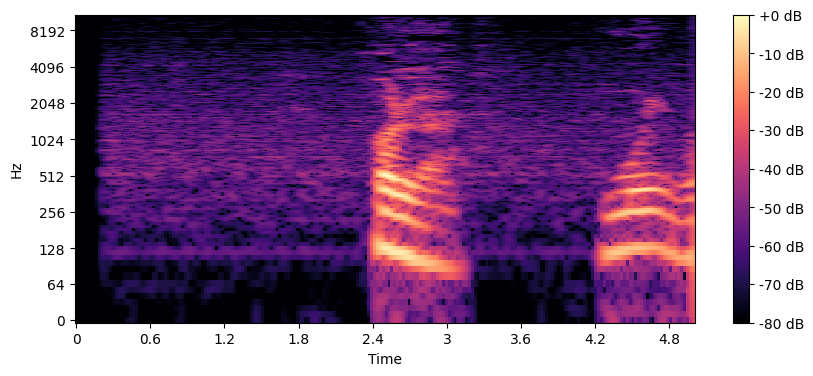

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Model

let's start with a simple CNN with the final layers fully connected

In [2]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    # initialize first set of CONV => RELU => POOL layers
    # input: 1025x216x1  output: 1025x216x4
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding='same')
    self.relu1 = nn.ReLU()
    # input: 1025x216x4  output 512x108x4
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize second set of CONV => RELU => POOL layers
    # input: 512x108x4  output 512x108x8
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding='same')
    self.relu2 = nn.ReLU()
    # input: 512x108x8  output 256x54x8
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize third set of CONV => RELU => POOL layers
    # input: 256x54x8  output 256x54x16
    self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='same')
    self.relu3 = nn.ReLU()
    # input: 256x54x16  output 128x27x16
    self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=55296, out_features=1024)
    self.relu4 = nn.ReLU()

    # initialize the sigmoid
    self.fc2 = nn.Linear(in_features=1024, out_features=1)
    self.sigmoid = nn.Sigmoid()

  # forward pass function
  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    # pass the output from the previous layer through the third set of CONV => RELU => POOL layers
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.maxpool3(x)

    # flatten the output from the previous layer and pass it through the FC => RELU layer
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu4(x)

    # pass the output to the sigmoid function to get the output predictions
    x = self.fc2(x)
    output = self.sigmoid(x)
    # return the output predictions
    return output

# Load training data

In [3]:
# define training hyperparameters
INIT_LR = 0.001
BATCH_SIZE = 50
EPOCHS = 15

at first, let's use 1000 training samples, with a 50/50 balance.

In [4]:
random.seed(42)
train_X = np.empty((0,1025,216))

with open('/content/gdrive/MyDrive/P6_files/fake_audio_spects_500.pkl', 'rb') as handle:
    tmp = pickle.load(handle)

train_X = np.concatenate((train_X, tmp), axis=0)

with open('/content/gdrive/MyDrive/P6_files/real_audio_spects_500.pkl', 'rb') as handle:
    tmp = pickle.load(handle)

train_X = np.concatenate((train_X, tmp), axis=0)

# the Labels are simply 0 for the first 500 samples, and 1 for the remaining 500
train_y = np.concatenate((np.zeros((500,)), np.ones((500,))))

# let's shuffle the data to mix it up
shuffled_indices = np.arange(len(train_X))
random.shuffle(shuffled_indices)

# Use the shuffled indices to shuffle both arrays
train_X = train_X[shuffled_indices]
train_y = train_y[shuffled_indices]

let's now get the test data.
For the time being, we are going to use 50 samples for each category taken from the last pickle file

In [5]:
test_X = np.empty((0,1025,216))
n_samples = 50

with open('/content/gdrive/MyDrive/P6_files/fake_audio_spects_3000.pkl', 'rb') as handle:
    tmp = pickle.load(handle)

test_X = np.concatenate((test_X, tmp[:n_samples]), axis=0)

with open('/content/gdrive/MyDrive/P6_files/real_audio_spects_3000.pkl', 'rb') as handle:
    tmp = pickle.load(handle)

test_X = np.concatenate((test_X, tmp[:n_samples]), axis=0)

# the Labels are simply 0 for the first n_samples, and 1 for the remaining n_samples
test_y = np.concatenate((np.zeros((n_samples,)), np.ones((n_samples,))))

# let's shuffle the data to mix it up
shuffled_indices = np.arange(len(test_X))
random.shuffle(shuffled_indices)

# Use the shuffled indices to shuffle both arrays
test_X = test_X[shuffled_indices]
test_y = test_y[shuffled_indices]

the values of X go from 0 to -80.

Let's normalize them between 0 and -1

In [6]:
# transform to torch tensor
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# perform the normalization
train_X /= 80.0
test_X /= 80.0

# create the datasets as Torch likes them
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_data_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Training

In [7]:
model = CNN().to(device)          # GPU

loss_fn = nn.BCELoss()
opt = Adam(model.parameters(), lr=INIT_LR)

In [10]:
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
  "train_precision": [],
  "train_recall": [],
  "train_f1": [],
	"test_loss": [],
	"test_acc": [],
  "test_precision": [],
  "test_recall": [],
  "test_f1": []
}

n_train_sample = train_X.shape[0]
n_test_sample = test_X.shape[0]


# loop over our epochs
for e in range(0, 1):

  # set the model in training mode -> the computational graphs are saved to be used in backprop
  model.train()

  # initialize the total training and test loss -> it will be used to compute the average epoch values
  total_train_loss = 0
  total_test_loss = 0

  # initialize the number of correct predictions in the training and test step -> used to compute accuracy
  train_correct = 0
  test_correct = 0

  # initialize the count of positive to compute the F1 score
  train_n_true_pos = 0
  train_n_pos = 0
  train_n_gt_pos = 0
  test_n_true_pos = 0
  test_n_pos = 0
  test_n_gt_pos = 0

  # loop over the training set
  for (x, y) in train_data_loader:

    (x, y) = (x.to(device), y.to(device))
    # zero out the gradients
    opt.zero_grad()

    x = torch.reshape(x, (BATCH_SIZE, 1, 1025, 216))
    # perform a forward pass and calculate the training loss
    pred = model(x)
    pred = torch.reshape(pred, (-1,))
    loss = loss_fn(pred, y)
    # perform the backpropagation step, and update the weights
    loss.backward()
    opt.step()

    # Compute the components for the F1 score
    correct_pred = (torch.round(pred) == y)
    train_n_true_pos += (torch.round(pred[correct_pred]) == 1).type(torch.float).sum().item()  # number of true positive
    train_n_pos += (torch.round(pred) == 1).type(torch.float).sum().item()                     # number of predicted positive
    train_n_gt_pos += (y == 1).type(torch.float).sum().item()                                  # number of expected positive

    n_correct = correct_pred.type(torch.float).sum().item()

    # compute the performance metrics
    total_train_loss += loss
    train_correct += n_correct


  # switch off autograd for evaluation
  with torch.no_grad():

    # set the model in evaluation mode
    model.eval()

    for (x, y) in test_data_loader:

      (x, y) = (x.to(device), y.to(device))

      x = torch.reshape(x, (BATCH_SIZE, 1, 1025, 216))
      # make the predictions and calculate the validation loss
      pred = model(x)
      pred = torch.reshape(pred, (-1,))

      loss = loss_fn(pred, y)

      # Compute the components for the F1 score
      correct_pred = (torch.round(pred) == y)
      test_n_true_pos += (torch.round(pred[correct_pred]) == 1).type(torch.float).sum().item()  # number of true positive
      test_n_pos += (torch.round(pred) == 1).type(torch.float).sum().item()                     # number of predicted positive
      test_n_gt_pos += (y == 1).type(torch.float).sum().item()                                  # number of expected positive

      n_correct = correct_pred.type(torch.float).sum().item()

      # compute the performance metrics
      total_test_loss += loss
      test_correct += n_correct

  # update our training history
  H["train_loss"].append(total_train_loss.cpu().detach().numpy() / n_train_sample)
  H["train_acc"].append(train_correct / n_train_sample)
  train_prec = train_n_true_pos / train_n_pos
  H["train_precision"].append(train_prec)
  train_recall = train_n_true_pos / train_n_gt_pos
  H["train_recall"].append(train_recall)
  H["train_f1"].append(2*(train_prec * train_recall) / (train_prec + train_recall))

  H["test_loss"].append(total_test_loss.cpu().detach().numpy() / n_test_sample)
  H["test_acc"].append(test_correct / n_test_sample)
  test_prec = test_n_true_pos / test_n_pos
  H["test_precision"].append(test_prec)
  test_recall = test_n_true_pos / test_n_gt_pos
  H["test_recall"].append(test_recall)
  H["test_f1"].append(2*(test_prec * test_recall) / (test_prec + test_recall))

  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
  print("Train loss: {:.4f}, Train correct: {:.2f} %".format(total_train_loss / n_train_sample *100, train_correct / n_train_sample * 100))
  print("Train precision: {:.4f}, Train recall: {:.4f},  Train F1 score: {:.4f}".format(train_prec, train_recall, H["train_f1"][-1]))
  print("Test loss: {:.4f}, Test correct: {:.2f} %".format(total_test_loss / n_test_sample*100, test_correct / n_test_sample* 100))
  print("Test precision: {:.4f}, Test recall: {:.4f},  Test F1 score: {:.4f}\n".format(test_prec, test_recall, H["test_f1"][-1]))


[INFO] EPOCH: 1/15
Train loss: 1.3718, Train correct: 56.10 %
Train precision: 0.5650, Train recall: 0.5300,  Train F1 score: 0.5470
Test loss: 1.0713, Test correct: 60.00 %
Test precision: 1.0000, Test recall: 0.2000,  Test F1 score: 0.3333

